# sCellST Benchmark (INT25-INT28)

## Environment
It is recommended to use a separate environment for sCellST.

```bash
conda create -n scellst_bench python=3.10
conda activate scellst_bench

# Install PyTorch (CUDA 11.8)
pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118

# Install other dependencies
pip install scanpy pandas numpy matplotlib seaborn scprep tqdm pytorch-lightning omegaconf loguru anndata scikit-learn dask[dataframe]

# Install sCellST dependencies if not covered above. Usually sCellST requires specific versions.
# Assuming sCellST source code is in benchmark/sCellST

# === IMPORTANT: OpenCV Fix ===
# If you encounter "DLL load failed" for cv2, try installing headless version:
pip uninstall opencv-python -y
pip install opencv-python-headless
```

In [1]:
import os
import sys
from pathlib import Path

# === Windows DLL Fix ===
# Fix for OSError: [WinError 1114] Error loading c10.dll / libiomp5md.dll etc.
if os.name == 'nt':
    conda_prefix = os.environ.get('CONDA_PREFIX')
    possible_paths = []
    if conda_prefix:
        possible_paths.append(Path(conda_prefix) / 'Library' / 'bin')
    
    # Add current python dir's Library/bin if distinct
    curr_python = sys.executable
    if curr_python:
        possible_paths.append(Path(curr_python).parent / 'Library' / 'bin')

    for p in possible_paths:
        if p.exists():
            print(f"Adding DLL path: {p}")
            os.environ['PATH'] = str(p) + os.pathsep + os.environ['PATH']
            try:
                os.add_dll_directory(str(p))
            except AttributeError:
                pass 

import pandas as pd
import numpy as np
import torch
import json
import shutil

# Set Paths
ROOT = Path(os.environ.get('MORPHO_VC_ROOT', '../')).expanduser().resolve()
BENCHMARK_DIR = ROOT / 'benchmark'
SCELLST_DIR = BENCHMARK_DIR / 'sCellST'
RESULT_DIR = BENCHMARK_DIR / 'results' / 'sCellST'
DATA_DIR = ROOT / 'data'
HEST_DIR = DATA_DIR / 'hest_data'

# Add paths to sys.path
# 1. sCellST
sys.path.append(str(SCELLST_DIR))

# 2. HEST (Local third_party)
HEST_SRC = ROOT / 'third_party' / 'HEST' / 'src'
if HEST_SRC.exists():
    print(f"Adding HEST local source: {HEST_SRC}")
    sys.path.insert(0, str(HEST_SRC))
else:
    print("Warning: local HEST source not found in third_party. If 'hest' is not installed via pip, this will fail.")

RESULT_DIR.mkdir(parents=True, exist_ok=True)

print(f"ROOT: {ROOT}")
print(f"HEST_DIR: {HEST_DIR}")
print(f"SCELLST_DIR: {SCELLST_DIR}")

# sCellST imports
# Fix for dask-expr RuntimeError in spatialdata
try:
    import dask
    dask.config.set({'dataframe.query-planning': False})
except ImportError:
    pass

try:
    from scellst.submit_function import embed_cells
    from scellst.dataset.data_module import STDataModule, MilVisiumHandler
    from scellst.utils.io_utils import load_config
    from scellst.utils.utils import prepare_model
    from scellst.trainer import prepare_trainer
    from omegaconf import OmegaConf, DictConfig
    from lightning.pytorch import seed_everything
    import lightning as L
    import scellst.type
    import scellst.lightning_model.gene_lightning_model
except ImportError as e:
    print("\n" + "="*60)
    print("IMPORT ERROR DETECTED")
    print(f"Error: {e}")
    if 'cv2' in str(e):
        print("\nSUGGESTION: This looks like an OpenCV DLL error.")
        print("Try running the following in your terminal:")
        print("  pip uninstall opencv-python -y")
        print("  pip install opencv-python-headless")
    elif 'loguru' in str(e):
        print("\nSUGGESTION: Missing 'loguru'. Install it via:")
        print("  pip install loguru")
    print("="*60 + "\n")
    raise e



from enum import Enum

# --- Fix 1: Runtime Monkeypatch for TaskType ---
# Fixes 'AttributeError: att_regression' by adding missing enum members at runtime
class PatchedTaskType(str, Enum):
    regression = "regression"
    nb_total_regression = "nb_total_regression"
    nb_mean_regression = "nb_mean_regression"
    # The missing members that cause the crash:
    bag_regression = "bag_regression"
    att_regression = "att_regression"

    @classmethod
    def list(cls):
        return list(map(lambda c: c.value, cls))

# Apply the patch
scellst.type.TaskType = PatchedTaskType

scellst.lightning_model.gene_lightning_model.TaskType = PatchedTaskType
print("Success: Monkeypatched TaskType to fix library inconsistencies.")

Adding DLL path: C:\ProgramData\anaconda3\envs\scellst_bench\Library\bin
Adding DLL path: c:\ProgramData\anaconda3\envs\scellst_bench\Library\bin
Adding HEST local source: D:\code\Morpho-VC\third_party\HEST\src
ROOT: D:\code\Morpho-VC
HEST_DIR: D:\code\Morpho-VC\data\hest_data
SCELLST_DIR: D:\code\Morpho-VC\benchmark\sCellST


c:\ProgramData\anaconda3\envs\scellst_bench\lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
c:\ProgramData\anaconda3\envs\scellst_bench\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


14:39:23 | INFO | PROJ_ROOT path is: D:\code\Morpho-VC\benchmark\sCellST


c:\ProgramData\anaconda3\envs\scellst_bench\lib\site-packages\xarray_schema\__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Success: Monkeypatched TaskType to fix library inconsistencies.


c:\ProgramData\anaconda3\envs\scellst_bench\lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


## 1. Prepare Data & Embeddings

Load common genes and generate cell embeddings using sCellST's Pre-trained ResNet50 (ImageNet).

In [2]:
# Load Common Genes
common_gene_path = DATA_DIR / 'spatial_data' / 'common_genes.txt'
with open(common_gene_path, 'r') as f:
    common_genes = [line.strip() for line in f.readlines()]
print(f"Loaded {len(common_genes)} common genes.")

# Slide Splits
train_ids = ['INT25', 'INT26']
val_ids = ['INT27']
test_ids = ['INT28']
all_ids = train_ids + val_ids + test_ids

# Generate Embeddings (if not exist)
# This step generates .h5 files in data/hest_data/cell_embeddings
# sCellST expects this structure.

TAG = "imagenet-rn50"
MODEL_NAME = "resnet50"
NORM_TYPE = "train"
SHAPE_NAME = "cellvit"

# Check if embeddings exist to avoid re-running
missing_emb = []
for sid in all_ids:
    emb_path = HEST_DIR / "cell_embeddings" / f"{TAG}_{NORM_TYPE}_{sid}_{SHAPE_NAME}.h5"
    if not emb_path.exists():
        missing_emb.append(sid)

if missing_emb:
    print(f"Generating embeddings for {missing_emb}...")
    
    # 1. Convert to sCellST format (generates cell_images/*.h5)
    # This step is required before embed_cells
    print("Step 1: Converting HEST data to sCellST format...")
    try:
        from scellst.cellhest_adapter.processing_utils import convert_to_cellst, filter_data
        
        # We need to pass technology list. Assuming Visium for these INT datasets.
        # Ideally we get this from HEST metadata but let's be explicit if we know.
        # Or we can query HEST metadata dataframe as sCellST does.
        df = pd.read_csv(ROOT / "third_party/HEST/assets/HEST_v1_1_0.csv")
        df = df.set_index("id")
        tech_list = []
        for sid in missing_emb:
            if sid in df.index:
                tech_list.append(df.loc[sid, "st_technology"])
            else:
                 # Fallback default
                 print(f"Warning: {sid} not found in HEST metadata csv, assuming Visium.")
                 tech_list.append("Visium")
        
        convert_to_cellst(
            path_dataset=HEST_DIR,
            ids_to_query=missing_emb,
            technology=tech_list,
            shape_name=SHAPE_NAME
        )
    except Exception as e:
        print(f"Error in convert_to_cellst: {e}")
        import traceback
        traceback.print_exc()

    # 2. Embed Cells
    print("Step 2: Generating Embeddings...")
    try:
        embed_cells(
            path_dataset=HEST_DIR,
            organ=None,
            ids_to_query=missing_emb,
            tag=TAG,
            model_name=MODEL_NAME,
            normalisation_type=NORM_TYPE,
            shape_name=SHAPE_NAME
        )
    except Exception as e:
        # Detailed error printing
        import traceback
        traceback.print_exc()
        print(f"Error generating embeddings: {e}")
        print("\nPotential Issues:")
        print("1. Missing source images/h5ad in hest_data?")
        print(f"   Checking {HEST_DIR} content:")
        if HEST_DIR.exists():
            print(f"   - {len(list(HEST_DIR.glob('*')))} files/dirs found.")
        else:
            print(f"   - {HEST_DIR} NOT FOUND!")
else:
    print("All embeddings found. Skipping generation.")

Loaded 17512 common genes.
All embeddings found. Skipping generation.


## 2. Training

Train using `INT25`, `INT26`. Validate on `INT27`.

In [3]:
# Load Default Config
config_path = SCELLST_DIR / "config" / "gene_default.yaml"
config = load_config(config_path)

# Override Config for Training - Following OFFICIAL sCellST settings
config.data.data_dir = str(HEST_DIR)
# Official approach: Include all training slides in list_training_ids
# The DataModule will automatically split them 80/20 for train/val
config.data.list_training_ids = train_ids + val_ids  # [INT25, INT26, INT27]
config.data.genes = common_genes
config.data.embedding_tag = f"{TAG}_{NORM_TYPE}"
config.data.batch_size = 64  # Official uses 128, reduced for GPU memory
config.data.frac_train = 0.8  # Official default - auto split
config.data.dataset_handler = "mil"
# task_type: Use 'regression' for MSE loss, or 'nb_mean_regression' for NB distribution
# Official model.yaml uses 'regression'
config.model.task_type = "regression"

# Setup output dir
save_dir = RESULT_DIR / "checkpoints"
save_dir.mkdir(parents=True, exist_ok=True)
best_model_path = save_dir / "best_model.ckpt"

seed_everything(config.data.seed)

# Single DataModule with internal train/val split (OFFICIAL approach)
print("Setting up DataModule (Train + Val internal split)...")
from scellst.dataset.data_module import STDataModule
from scellst.dataset.data_handler import MilVisiumHandler

data_dm = STDataModule(
    data_dir=Path(config.data.data_dir),
    list_training_ids=config.data.list_training_ids,
    genes=config.data.genes,
    embedding_tag=config.data.embedding_tag,
    dataset_handler=MilVisiumHandler(),
    batch_size=config.data.batch_size,
    frac_train=config.data.frac_train,  # 0.8 - auto 80/20 split
    fold=-1,  # Use all slides
    predict_id=None,
    num_workers=0,  # Windows compatibility
)
data_dm.prepare_data()
data_dm.setup(stage="fit")

print(f"Train samples: {len(data_dm.train_dataset)}, Val samples: {len(data_dm.val_dataset)}")

# Model
config.model.gene_names = data_dm.get_gene_names()
config.predictor.output_dim = len(config.model.gene_names)
model = prepare_model(config)

# Check if existing checkpoint exists - LOAD instead of retrain
if best_model_path.exists():
    print(f"Found existing checkpoint at {best_model_path}")
    print("Loading pre-trained model (to retrain, delete the checkpoint file first)...")
    # Load weights from checkpoint
    model = type(model).load_from_checkpoint(best_model_path, weights_only=False)
    ckpt_path = str(best_model_path)
    print(f"Model loaded successfully from: {ckpt_path}")
else:
    print("No existing checkpoint found. Starting training...")
    
    # Trainer with Progress Bar (NO TensorBoard/WandB)
    from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, RichProgressBar
    from lightning.pytorch.loggers import CSVLogger
    import lightning.pytorch.callbacks as pl_callbacks
    
    checkpoint_callback = ModelCheckpoint(
        dirpath=save_dir,
        filename='best_model',
        save_top_k=1,
        monitor='val_loss',
        mode='min'
    )
    
    # Official settings: patience=20, max_epochs=400
    es_callback = EarlyStopping(monitor='val_loss', patience=20, mode='min')
    
    # Custom callback: Print one line per epoch for user feedback
    class SimpleEpochProgress(pl_callbacks.Callback):
        def on_train_epoch_end(self, trainer, pl_module):
            metrics = trainer.callback_metrics
            loss = metrics.get("val_loss", float('nan'))
            train_loss = metrics.get("train_loss", float('nan'))
            # Only print if val_loss is available (i.e., after validation runs)
            if not isinstance(loss, float) or loss != float('nan'):
                print(f"Epoch {trainer.current_epoch}: train_loss={float(train_loss):.4f}, val_loss={float(loss):.4f}")
    
    trainer = L.Trainer(
        max_epochs=400,  # Official default
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[
            checkpoint_callback,
            es_callback,
            RichProgressBar(),
            SimpleEpochProgress()
        ],
        default_root_dir=save_dir,
        enable_progress_bar=True,
        logger=CSVLogger(save_dir),
        log_every_n_steps=10,
    )
    
    print("Training with OFFICIAL settings: max_epochs=400, patience=20...")
    # Train using OFFICIAL approach: train_dataloader + val_dataloader from SAME DataModule
    trainer.fit(
        model,
        train_dataloaders=data_dm.train_dataloader(),
        val_dataloaders=data_dm.val_dataloader()
    )
    ckpt_path = checkpoint_callback.best_model_path
    print(f"Training finished. Best model saved to: {ckpt_path}")

Seed set to 0


Setting up DataModule (Train + Val internal split)...
14:39:32 | INFO | Preparing data for training.
14:39:32 | INFO | Preparing data for ID: INT25.
14:39:32 | INFO | Loading data for ID: INT25
14:39:32 | INFO | Loaded adata with shape: (3808, 17943)
14:39:32 | INFO | First obs names: Index(['AAACAAGTATCTCCCA-1_INT25', 'AAACACCAATAACTGC-1_INT25',
       'AAACAGAGCGACTCCT-1_INT25', 'AAACAGGGTCTATATT-1_INT25',
       'AAACATTTCCCGGATT-1_INT25'],
      dtype='object')
14:39:32 | INFO | After genes filtering: (3808, 9795)
14:39:32 | INFO | After count filtering: (3804, 9795)
14:39:32 | INFO | After mt and rps filtering: 9795
14:39:32 | INFO | Normalising spot counts.
14:39:32 | INFO | Log1p transform counts.
14:39:32 | INFO | Found 3440 / 3804 spots in the adata file.
14:39:32 | INFO | Found 3440 / 3440 spots in the cell embedding file.
14:39:32 | INFO | Preprocessing completed.
14:39:32 | INFO | Selecting genes from list.
14:39:32 | INFO | Found 9586 / 17512 genes in adata.var_names
14:39

c:\ProgramData\anaconda3\envs\scellst_bench\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Found existing checkpoint at D:\code\Morpho-VC\benchmark\results\sCellST\checkpoints\best_model.ckpt
Loading pre-trained model (to retrain, delete the checkpoint file first)...
14:39:40 | INFO | GeneLightningModel(
  (train_metrics): MetricCollection(
    (mse): MeanSquaredError()
    (pcc): PearsonCorrCoef(),
    prefix=val/
  )
  (valid_metrics): MetricCollection(
    (mse): MeanSquaredError()
    (pcc): PearsonCorrCoef(),
    prefix=val/
  )
  (test_metrics): MetricCollection(
    (mse): MeanSquaredError()
    (pcc): PearsonCorrCoef()
    (scc): SpearmanCorrCoef()
  )
  (model): InstanceMilModel(
    (gene_predictor): GenePredictor(
      (final_activation_layer): Softplus(beta=20, threshold=20.0)
      (model): Sequential(
        (0): Sequential(
          (0): Linear(in_features=2048, out_features=256, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_

## 3. Prediction (INT28)

Load best model and predict on `INT28`.

In [4]:
# --- Manual Prediction Setup ---
print(f"Loading model from {ckpt_path}")
# FIX: Set weights_only=False to fix UnpicklingError with DictConfig
model = type(model).load_from_checkpoint(ckpt_path, weights_only=False)
model.eval()
model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Retrieve the exact gene list used during training (from model hparams)
train_gene_names = model.gene_names
print(f"Model expects {len(train_gene_names)} genes.")

# Manually load and align data for prediction
predict_id = test_ids[0]
print(f"Manually preparing prediction data for ID: {predict_id}")

handler = MilVisiumHandler()
embedding_path = Path(config.data.data_dir) / "cell_embeddings" / f"{config.data.embedding_tag}_{predict_id}_{config.data.shape_name}.h5"

# Load adata - this sets adata.uns["cell_embedding_path"] and adata.uns["spot_cell_map"]
adata = handler.load_and_preprocess_data(
    data_dir=Path(config.data.data_dir),
    id=predict_id,
    filter_genes=config.data.filter_genes,
    filter_cells=config.data.filter_cells,
    normalize=config.data.normalize,
    log1p=config.data.log1p,
    embedding_path=embedding_path,
    shape_name=config.data.shape_name,
)

# Convert sparse to dense if needed (same as STDataModule)
from scipy.sparse import issparse
if issparse(adata.X):
    adata.X = adata.X.toarray()

# --- Gene Alignment Logic ---
import pandas as pd
import anndata as ad
import scipy.sparse
import numpy as np

# CRITICAL: Backup ALL metadata before any transformation
# EmbeddedMilDataset requires both of these
saved_uns = adata.uns.copy()
saved_obsm = adata.obsm.copy() if hasattr(adata, 'obsm') and len(adata.obsm) > 0 else {}
saved_obs = adata.obs.copy()

# 1. Filter out genes not in training set (common genes)
common = sorted(list(set(adata.var_names).intersection(train_gene_names)))
adata = adata[:, common].copy()

# 2. Identify missing genes
missing_genes = sorted(list(set(train_gene_names) - set(adata.var_names)))

if len(missing_genes) > 0:
    print(f"Warning: Prediction set is missing {len(missing_genes)} genes. Filling with zeros.")
    
    # Prepare zero-filled matrix for missing genes
    zero_X = np.zeros((adata.n_obs, len(missing_genes)), dtype=adata.X.dtype)
    
    # Concatenate horizontally
    new_X = np.hstack([adata.X, zero_X])
    new_var_names = list(adata.var_names) + missing_genes
    
    # Create new AnnData with combined data
    adata = ad.AnnData(
        X=new_X,
        obs=saved_obs,  # Use saved obs
        var=pd.DataFrame(index=new_var_names),
    )

# CRITICAL: Restore metadata after transformation
adata.uns = saved_uns
if saved_obsm:
    adata.obsm = saved_obsm

# 3. Reorder strictly to match training genes order
# AND backup/restore uns again because slicing can drop it
saved_uns_final = adata.uns.copy()
adata = adata[:, train_gene_names].copy()
adata.uns = saved_uns_final

print(f"Aligned adata shape: {adata.shape}")
print(f"adata.uns keys: {list(adata.uns.keys())}")

# Create Dataset manually
# MilVisiumHandler.create_dataset expects adata with:
# - adata.uns["cell_embedding_path"]
# - adata.uns["spot_cell_map"] 
# - adata.obs["size_factor"]
predict_ds = handler.create_dataset(adata, embedding_path)

# Keep spot order for plotting; order matches pred_bag/true_bag
pred_spot_ids_raw = adata.obs_names.to_list()
suffix = f"_{predict_id}"
pred_spot_ids = [s[:-len(suffix)] if s.endswith(suffix) else s for s in pred_spot_ids_raw]

# Save spot IDs alongside predictions (for plotting in a fresh kernel)
np.save(RESULT_DIR / 'pred_spot_ids.npy', np.array(pred_spot_ids, dtype=object))

# Create DataLoader with custom_collate (required for MIL)
from torch.utils.data import DataLoader
from scellst.dataset.dataset_utils import custom_collate
from scellst.constant import REGISTRY_KEYS

loader = DataLoader(
    predict_ds, 
    batch_size=config.data.batch_size, 
    shuffle=False, 
    num_workers=0,
    collate_fn=custom_collate
)

# Prediction Loop
preds = []
truths = []

print(f"Predicting on {predict_id}...")
from tqdm import tqdm
import sys

with torch.no_grad():
    for batch in tqdm(loader, desc="Predicting", file=sys.stdout):
        batch_to_device = {}
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch_to_device[k] = v.to(model.device)
            else:
                batch_to_device[k] = v
        
        # Call internal model forward (model.model is InstanceDistributionMilModel)
        bag_dict, _ = model.model(batch_to_device)
        
        # CORRECT KEY: REGISTRY_KEYS.OUTPUT_PREDICTION = "output_prediction"
        pred = bag_dict[REGISTRY_KEYS.OUTPUT_PREDICTION].cpu().numpy()
        
        # CORRECT KEY: REGISTRY_KEYS.Y_BAG_KEY = "Y_bag"
        truth = batch[REGISTRY_KEYS.Y_BAG_KEY].cpu().numpy()
        
        preds.append(pred)
        truths.append(truth)

pred_bag = np.concatenate(preds, axis=0)
true_bag = np.concatenate(truths, axis=0)

print(f"Prediction shape: {pred_bag.shape}")
print(f"Truth shape: {true_bag.shape}")

# Save Results
np.save(RESULT_DIR / 'pred_bag.npy', pred_bag)
np.save(RESULT_DIR / 'true_bag.npy', true_bag)
print(f"Saved results to {RESULT_DIR}")

Loading model from D:\code\Morpho-VC\benchmark\results\sCellST\checkpoints\best_model.ckpt
14:39:41 | INFO | GeneLightningModel(
  (train_metrics): MetricCollection(
    (mse): MeanSquaredError()
    (pcc): PearsonCorrCoef(),
    prefix=val/
  )
  (valid_metrics): MetricCollection(
    (mse): MeanSquaredError()
    (pcc): PearsonCorrCoef(),
    prefix=val/
  )
  (test_metrics): MetricCollection(
    (mse): MeanSquaredError()
    (pcc): PearsonCorrCoef()
    (scc): SpearmanCorrCoef()
  )
  (model): InstanceMilModel(
    (gene_predictor): GenePredictor(
      (final_activation_layer): Softplus(beta=20, threshold=20.0)
      (model): Sequential(
        (0): Sequential(
          (0): Linear(in_features=2048, out_features=256, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
          (2): 

## 4. Evaluation

Calculate MAE, RMSE, Pearson Correlation.

Loading spatial data from: D:\code\Morpho-VC\data\spatial_data\INT28.h5ad
Aligned spatial coords to 3849 predicted spots.
Coords Range: X[2884.0, 12363.0], Y[1598.0, 11420.0]
Found WSI: D:\code\Morpho-VC\data\hest_data\wsis\INT28.tif
Using pixel-space extent (0..W, H..0) for alignment.


c:\ProgramData\anaconda3\envs\scellst_bench\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\ProgramData\anaconda3\envs\scellst_bench\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


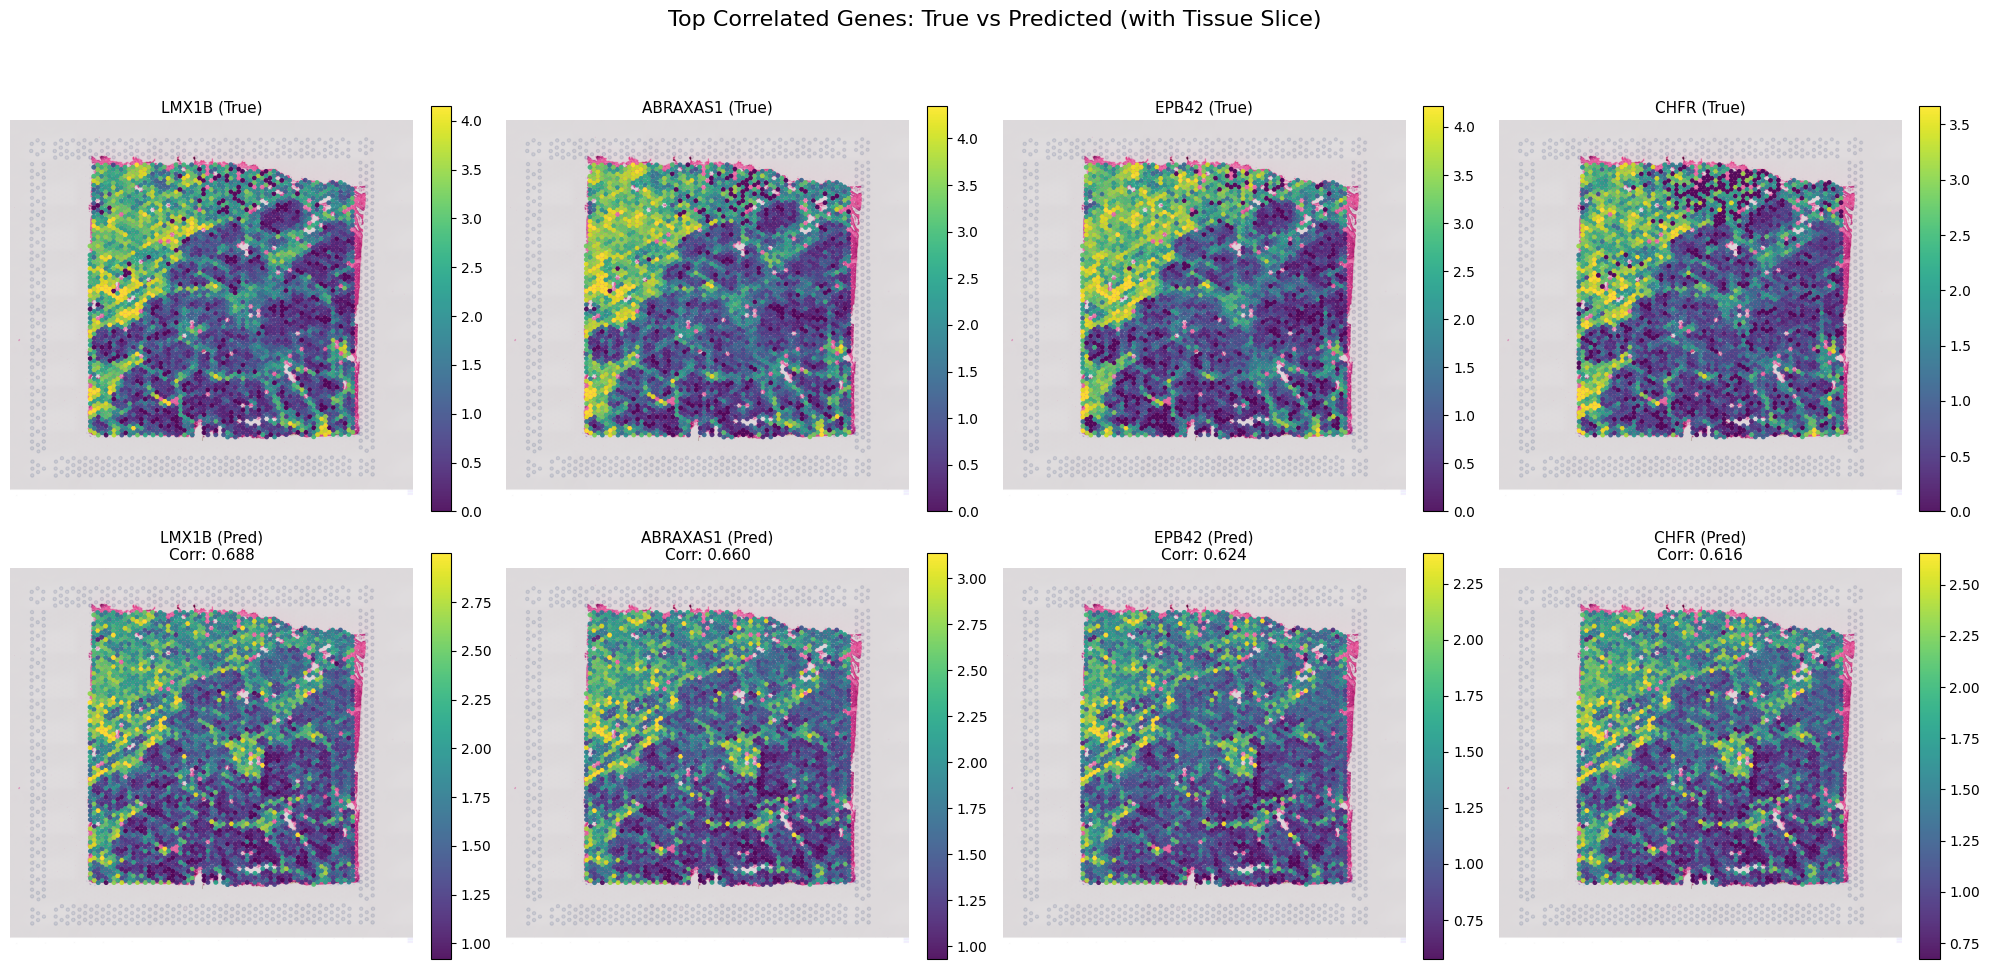

In [5]:
# === Visualizing Spatial Gene-Expression (Top-4) WITH Tissue Slice Background ===
import os
from pathlib import Path

import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

# Optional: background loading
try:
    from PIL import Image
except ImportError:
    Image = None

def robust_vmin_vmax(arr, p_low=1, p_high=99):
    """
    Compute (vmin, vmax) from *this panel's* values only (robust percentiles).
    Each panel (each subplot) can have its own scale.
    """
    a = np.asarray(arr, dtype=float)
    a = a[np.isfinite(a)]
    if a.size == 0:
        return 0.0, 1.0

    vmin, vmax = np.percentile(a, [p_low, p_high])
    if (not np.isfinite(vmin)) or (not np.isfinite(vmax)) or (vmin == vmax):
        vmin, vmax = float(np.min(a)), float(np.max(a))
        if vmin == vmax:
            eps = 1e-6 if vmin == 0 else abs(vmin) * 1e-6
            vmin, vmax = vmin - eps, vmax + eps
    return vmin, vmax

# ----------------------------
# 0) Paths & IDs
# ----------------------------
TEST_ID = "INT28"

ROOT = Path(os.environ.get("MORPHO_VC_ROOT", "../")).expanduser().resolve()
DATA_DIR = ROOT / "data" / "spatial_data"
HEST_DIR = ROOT / "data" / "hest_data"

h5ad_path = DATA_DIR / f"{TEST_ID}.h5ad"
if not h5ad_path.exists():
    # fallback (keep your style)
    h5ad_path = Path(f"../../data/spatial_data/{TEST_ID}.h5ad").resolve()

print(f"Loading spatial data from: {h5ad_path}")

# ----------------------------
# 1) Load spatial coords
# ----------------------------
try:
    adata_spatial = sc.read_h5ad(h5ad_path)

    # Align coords to prediction spot order (pred_bag/true_bag)
    pred_spot_ids_local = None
    if "pred_spot_ids" in locals():
        pred_spot_ids_local = list(pred_spot_ids)
    else:
        pred_spot_path = ROOT / "benchmark" / "results" / "sCellST" / "pred_spot_ids.npy"
        if pred_spot_path.exists():
            pred_spot_ids_local = np.load(pred_spot_path, allow_pickle=True).tolist()

    if pred_spot_ids_local is not None:
        suffix = f"_{TEST_ID}"
        if any(s.endswith(suffix) for s in pred_spot_ids_local):
            pred_spot_ids_local = [
                s[:-len(suffix)] if s.endswith(suffix) else s for s in pred_spot_ids_local
            ]
        pred_spot_ids_local = [
            s for s in pred_spot_ids_local if s in adata_spatial.obs_names
        ]
        if len(pred_spot_ids_local) == 0:
            raise ValueError("pred_spot_ids empty after alignment; cannot align coords.")
        adata_spatial = adata_spatial[pred_spot_ids_local].copy()
        print(f"Aligned spatial coords to {len(pred_spot_ids_local)} predicted spots.")
    else:
        print("WARNING: pred_spot_ids not found; using full spatial adata ordering.")

    coords = adata_spatial.obsm["spatial"]  # shape (N, 2)
    x, y = coords[:, 0], coords[:, 1]

    min_x, min_y = coords.min(axis=0)
    max_x, max_y = coords.max(axis=0)
    print(f"Coords Range: X[{min_x:.1f}, {max_x:.1f}], Y[{min_y:.1f}, {max_y:.1f}]")
except Exception as e:
    print(f"[ERROR] Failed to load spatial coords: {e}")
    # Fallback
    n_points = 100
    if 'pred_bag' in locals(): n_points = pred_bag.shape[0]
    x, y = np.random.rand(n_points), np.random.rand(n_points)
    min_x, min_y, max_x, max_y = x.min(), y.min(), x.max(), y.max()

# ----------------------------
# 2) Try load WSI background (tissue slice)
# ----------------------------
bg_img = None
bg_extent = None

wsi_files = list((HEST_DIR / "wsis").glob(f"{TEST_ID}.*"))
if len(wsi_files) > 0:
    wsi_path = wsi_files[0]
    print(f"Found WSI: {wsi_path}")

    try:
        import openslide  # noqa: F401
        slide = openslide.OpenSlide(str(wsi_path))
        w0, h0 = slide.dimensions
        thumb_w = 2000
        scale = thumb_w / w0
        thumb_h = int(h0 * scale)
        bg_img = slide.get_thumbnail((thumb_w, thumb_h))
        in_pixel_space = (
            (min_x >= -0.05 * w0) and (max_x <= 1.05 * w0) and
            (min_y >= -0.05 * h0) and (max_y <= 1.05 * h0)
        )
        if in_pixel_space:
            bg_extent = (0, w0, h0, 0)
            print("Using pixel-space extent (0..W, H..0) for alignment.")
        else:
            bg_extent = (min_x, max_x, max_y, min_y)
            print("Coords not in pixel space; stretching background to coords bounding box.")
    except Exception as e:
        print(f"OpenSlide failed ({e}), trying PIL...")
        try:
            if hasattr(Image, 'MAX_IMAGE_PIXELS'):
                Image.MAX_IMAGE_PIXELS = None
            img = Image.open(wsi_path)
            w0, h0 = img.size
            img.thumbnail((2000, 2000))
            bg_img = img
            in_pixel_space = (
                (min_x >= -0.05 * w0) and (max_x <= 1.05 * w0) and
                (min_y >= -0.05 * h0) and (max_y <= 1.05 * h0)
            )
            if in_pixel_space:
                bg_extent = (0, w0, h0, 0)
                print("Using pixel-space extent (0..W, H..0) for alignment.")
            else:
                bg_extent = (min_x, max_x, max_y, min_y)
                print("Coords not in pixel space; stretching background to coords bounding box.")
        except Exception as e2:
            print(f"[WARNING] PIL background load failed: {e2}")
            bg_img, bg_extent = None, None
else:
    print("[INFO] No WSI found under:", (HEST_DIR / "wsis"))

# ----------------------------
# 3) Pick Top-4 genes by correlation
# ----------------------------
try:
    # Standard sCellST vars
    P = None
    T = None
    if 'pred_bag' in locals() and 'true_bag' in locals():
        P = pred_bag
        T = true_bag
    
    if P is not None and T is not None:
        if 'valid' not in locals(): 
             # Recalc correlations if missing
             valid = []
             for i in range(T.shape[1]):
                  c = np.corrcoef(T[:,i], P[:,i])[0,1]
                  if np.isfinite(c): valid.append((i, c))
        
        sorted_genes = sorted(valid, key=lambda t: t[1], reverse=True)
        top4_genes = sorted_genes[:4]
        n_show = len(top4_genes)
    else:
        print("CRITICAL: pred_bag/true_bag not found.")
        n_show = 0

except Exception as e:
    print(f"Error selecting genes: {e}")
    n_show = 0

# ----------------------------
# 4) Plot (2 rows: True vs Pred)
# ----------------------------
if n_show > 0:
    if P.shape[0] != x.shape[0]:
        raise ValueError(
            f"Pred({P.shape[0]}) vs Coords({x.shape[0]}) mismatch after alignment. "
            "Check pred_spot_ids and spatial coords order."
        )

    fig, axes = plt.subplots(2, n_show, figsize=(5 * n_show, 10))
    if n_show == 1:
        # keep axes 2D: axes[row, col]
        axes = np.array(axes).reshape(2, 1)

    fig.suptitle("Top Correlated Genes: True vs Predicted (with Tissue Slice)", fontsize=16, y=0.98)

    for i, (gene_idx, corr) in enumerate(top4_genes):
        if 'common_genes' in locals() and gene_idx < len(common_genes):
            gene_name = common_genes[gene_idx]
        else:
            gene_name = f"Gene_{gene_idx}"

        gt_expr = T[:, gene_idx]
        pr_expr = P[:, gene_idx]

        # Panel-wise dynamic range
        vmin_gt, vmax_gt = robust_vmin_vmax(gt_expr, p_low=1, p_high=99)
        vmin_pr, vmax_pr = robust_vmin_vmax(pr_expr, p_low=1, p_high=99)

        # --- Row 1: Ground Truth ---
        ax_gt = axes[0, i]
        if bg_img is not None and bg_extent is not None:
            ax_gt.imshow(bg_img, extent=bg_extent)
        sc_gt = ax_gt.scatter(
            x, y, c=gt_expr, cmap="viridis", s=12, alpha=0.9,
            vmin=vmin_gt, vmax=vmax_gt, edgecolors="none"
        )
        ax_gt.set_title(f"{gene_name} (True)", fontsize=11)
        ax_gt.axis("off")
        if bg_img is None:
            ax_gt.invert_yaxis()
        plt.colorbar(sc_gt, ax=ax_gt, fraction=0.046, pad=0.04)

        # --- Row 2: Prediction ---
        ax_pr = axes[1, i]
        if bg_img is not None and bg_extent is not None:
            ax_pr.imshow(bg_img, extent=bg_extent)
        sc_pr = ax_pr.scatter(
            x, y, c=pr_expr, cmap="viridis", s=12, alpha=0.9,
            vmin=vmin_pr, vmax=vmax_pr, edgecolors="none"
        )
        ax_pr.set_title(f"{gene_name} (Pred)\nCorr: {corr:.3f}", fontsize=11)
        ax_pr.axis("off")
        if bg_img is None:
            ax_pr.invert_yaxis()
        plt.colorbar(sc_pr, ax=ax_pr, fraction=0.046, pad=0.04)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
